# WCS Reprojection Usage Examples (XRADIO)

This notebook **generates synthetic XRADIO images** using `xradio.image.make_empty_sky_image`,
then demonstrates WCS-aware reprojection with `wcs_reproject.py`.

Each example explains:
- the goal of the reprojection,
- what you should see in the output image,
- which quantity is expected to be conserved **based on the brightness unit**, and why.


## Setup
This section imports dependencies and defines helpers for generating synthetic XRADIO images.
The generated images are small so the examples run quickly.


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from xradio.image import make_empty_sky_image
from wcs_reproject import reproject_to_match, reproject_to_frame

def _gaussian_2d(l_vals, m_vals, amp, l0, m0, sigma_l, sigma_m):
    ll, mm = np.meshgrid(l_vals, m_vals, indexing='ij')
    rr = ((ll - l0) / sigma_l) ** 2 + ((mm - m0) / sigma_m) ** 2
    return amp * np.exp(-0.5 * rr)

def _make_template(n_l, n_m, cell_arcsec, frame='fk5', projection='SIN'):
    phase_center = [0.0, 0.0]  # [ra, dec] in rad
    image_size = [n_l, n_m]
    cell = np.deg2rad(cell_arcsec / 3600.0)
    cell_size = [cell, cell]
    frequency_coords = np.array([1.4e9])
    pol_coords = ['I']
    time_coords = np.array([59000.0])

    return make_empty_sky_image(
        phase_center=phase_center,
        image_size=image_size,
        cell_size=cell_size,
        frequency_coords=frequency_coords,
        pol_coords=pol_coords,
        time_coords=time_coords,
        direction_reference=frame,
        projection=projection,
        spectral_reference='lsrk',
        do_sky_coords=True,
    )

def _attach_sky(xds, sky_vals, units):
    dims = ('time', 'frequency', 'polarization', 'l', 'm')
    coords = {d: xds.coords[d] for d in dims}
    xds['SKY'] = xr.DataArray(sky_vals, dims=dims, coords=coords)
    xds['SKY'].attrs.update({'image_type': 'Intensity', 'type': 'sky', 'units': units})
    xds.attrs['data_groups'] = {'base': {'sky': 'SKY'}}
    xds.attrs['type'] = 'image_dataset'
    return xds

def _make_point_source_jy_per_pixel(n_l=128, n_m=128, cell_arcsec=2.0, loc=None):
    xds = _make_template(n_l, n_m, cell_arcsec, frame='fk5')
    base = np.zeros((n_l, n_m), dtype=np.float64)
    if loc is None:
        base[n_l // 2, n_m // 2] = 1.0
    else:
        base[loc] = 1.0
    sky = base[None, None, None, :, :]
    return _attach_sky(xds, sky, units='Jy/pixel')

def _make_gaussian_jy_per_beam(n_l=128, n_m=128, cell_arcsec=2.0):
    xds = _make_template(n_l, n_m, cell_arcsec, frame='fk5')
    l = xds.coords['l'].values
    m = xds.coords['m'].values
    base = _gaussian_2d(
        l, m, amp=1.0,
        l0=l[n_l // 2],
        m0=m[n_m // 2],
        sigma_l=5e-5,
        sigma_m=3e-5,
    )
    sky = base[None, None, None, :, :]
    return _attach_sky(xds, sky, units='Jy/beam')

def _plot_plane(da, title):
    arr = da.isel(time=0, frequency=0, polarization=0).values
    plt.figure(figsize=(4, 4))
    plt.imshow(arr, origin='lower')
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()


## Example 1: Reproject to Match a Target Grid (Jy/pixel)
**Goal:** reproject a `Jy/pixel` source image onto a target image with a different pixel size.

**Expected output:**
- Output has the same shape and grid as the target.
- The point source should remain centered, but the pixel sampling changes.

**Quantity conserved:** **integrated flux**.
- `Jy/pixel` represents flux per pixel area.
- When pixel sizes change, total integrated flux should be preserved.
- Use a **flux-conserving** method (e.g. `exact` or `adaptive`).


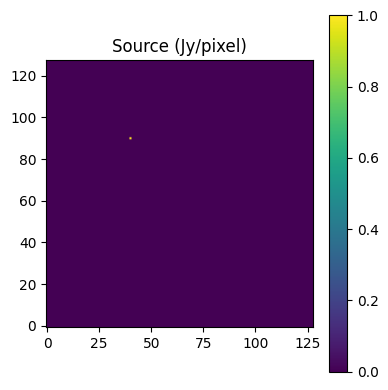

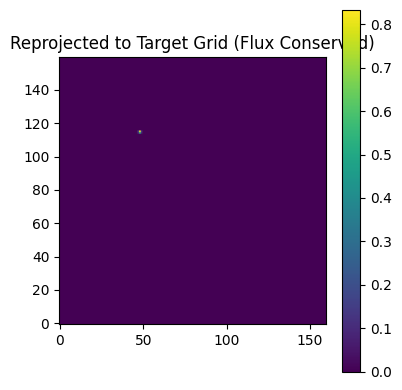

In [49]:
src = _make_point_source_jy_per_pixel(n_l=128, n_m=128, cell_arcsec=2.0, loc=(90,40))
tgt = _make_template(n_l=160, n_m=160, cell_arcsec=1.5, frame='fk5')

out = reproject_to_match(src, tgt, data_group='base', method='exact')

_plot_plane(src['SKY'], 'Source (Jy/pixel)')
_plot_plane(out['SKY'], 'Reprojected to Target Grid (Flux Conserved)')

In [79]:
flux = {}
ra = {}
dec = {}
dl = {}
dm = {}
for xds, label in zip([src,out], ["input", "output"]):
    sky = xds["SKY"]
    print(f"{label} shape: {sky.shape}")
    l = np.rad2deg(xds.l.values) * 3600
    m = np.rad2deg(xds.m.values) * 3600
    dl[label] = abs(l[1] - l[0])
    dm[label] = abs(m[1] - m[0])
    pixel_area = dl[label] * dm[label]
    flux[label] = float(xds.SKY.sum().values) * pixel_area
    print(
        f"{label} cell size: {dl} x {dm} arcsec"
    )
    print(f"{label} area-weighted sum (flux): {flux[label]}")
    arr = sky.values
    idx = np.unravel_index(np.argmax(arr), arr.shape)
    idx_list = [int(i) for i in idx]
    print(f"{label} max value pixel coord: {idx_list}")
    print("ra shape", xds["right_ascension"].shape)
    ra[label] = xds["right_ascension"].values[idx_list[3], idx_list[4]]
    dec[label] = xds["declination"].values[idx_list[3], idx_list[4]]
    print(f"{label} max value world coord (ra, dec): {ra}, {dec}")
result = "flux is conserved as" if np.isclose(flux["input"], flux["output"], rtol=1e-4) else "flux is not conserved which is not"
diff = np.abs(1 - flux["output"]/flux["input"])
result += f" expected for this case. Relative difference: {diff}"
print()
print(result)
ra_diff = np.rad2deg(
    abs(ra["output"] - ra["input"])*3600*np.cos(dec["input"])
)
dec_diff = np.rad2deg(abs(dec["output"] - dec["input"])) * 3600
print(
    f"ra, dec difference of peak: {ra_diff}, {dec_diff} arcsec"
)
if (
    ra_diff <= max(dl["input"], dl["output"])
    and dec_diff <= max(dm["input"], dm["output"])
):
    res = "less"
else:
    res = "greater"
print(f"world coord difference {res} than larger pixel size")

    
    


input shape: (1, 1, 1, 128, 128)
input cell size: {'input': np.float64(1.9999999999999858)} x {'input': np.float64(1.9999999999999858)} arcsec
input area-weighted sum (flux): 3.999999999999943
input max value pixel coord: [0, 0, 0, 90, 40]
ra shape (128, 128)
input max value world coord (ra, dec): {'input': np.float64(6.2829332040559125)}, {'input': np.float64(-0.00023271056903308488)}
output shape: (1, 1, 1, 160, 160)
output cell size: {'input': np.float64(1.9999999999999858), 'output': np.float64(1.5000000000000142)} x {'input': np.float64(1.9999999999999858), 'output': np.float64(1.5000000000000142)} arcsec
output area-weighted sum (flux): 4.000060877798576
output max value pixel coord: [0, 0, 0, 115, 48]
ra shape (160, 160)
output max value world coord (ra, dec): {'input': np.float64(6.2829332040559125), 'output': np.float64(6.282930779987363)}, {'input': np.float64(-0.00023271056903308488), 'output': np.float64(-0.0002327105690329507)}

flux is conserved as expected for this case.

## Example 2: Reproject to Match a Target Grid (Jy/beam)
**Goal:** reproject a `Jy/beam` image to a target grid using interpolation.

**Expected output:**
- Output has the same shape and grid as the target.
- The Gaussian source should preserve its **local shape and peak** approximately.

**Quantity conserved:** **local intensity pattern**, not total flux.
- `Jy/beam` is beam-normalized brightness.
- Interpolation preserves local structure, which is the usual scientific invariant.


In [ ]:
src = _make_gaussian_jy_per_beam(n_l=128, n_m=128, cell_arcsec=2.0)
tgt = _make_template(n_l=160, n_m=160, cell_arcsec=1.5, frame='fk5')

out = reproject_to_match(src, tgt, data_group='base', method='interp', order=1)

_plot_plane(src['SKY'], 'Source (Jy/beam)')
_plot_plane(out['SKY'], 'Reprojected to Target Grid (Interpolated)')


## Example 3: Reproject to a New Sky Frame (ICRS -> Galactic)
**Goal:** change the sky frame while keeping the same pixel grid.

**Expected output:**
- Output retains the original grid shape.
- The source appears **rotated** in the new frame.

**Quantity conserved:**
- If `Jy/pixel` and using `exact/adaptive`, total flux is conserved.
- If `Jy/beam` and using `interp`, local intensity patterns are preserved.


In [ ]:
src = _make_gaussian_jy_per_beam(n_l=128, n_m=128, cell_arcsec=2.0)

out = reproject_to_frame(src, 'galactic', keep_grid=True, method='interp', order=1)

_plot_plane(src['SKY'], 'Source (FK5)')
_plot_plane(out['SKY'], 'Reprojected to Galactic Frame (Same Grid)')


## Example 4: Reproject to a New Frame With Re-Centered Grid (Jy/pixel)
**Goal:** change to a new frame and rebuild a same-sized grid centered in the target frame.

**Expected output:**
- Same shape and pixel size as the source.
- Spatial coordinates re-centered for the target frame.

**Quantity conserved:** **integrated flux** for `Jy/pixel` when using a flux-conserving method.


In [ ]:
src = _make_point_source_jy_per_pixel(n_l=128, n_m=128, cell_arcsec=2.0)

out = reproject_to_frame(src, 'galactic', keep_grid=False, method='exact')

_plot_plane(src['SKY'], 'Source (Jy/pixel, FK5)')
_plot_plane(out['SKY'], 'Reprojected to Galactic (Re-centered Grid)')
